# Package Imports

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

import plotly
plotly.offline.init_notebook_mode(connected=True)

import sys
sys.path.append("..")

In [2]:
import thor

config = thor.Config()

In [3]:
DATABASE = "../data/msst_survey.db"
con = sql.connect(DATABASE)

## Config

In [4]:
from thor import propagateTestParticle

## Plotting Code

In [5]:
from thor.plotting import plotProjections
from thor.plotting import plotProjections3D
from thor.plotting import plotObservations
from thor.plotting import plotObservations3D
from thor.plotting import plotBinnedContour
from thor.plotting import plotScatterContour
from thor.plotting import plotCell
from thor.plotting import plotProjectionVelocitiesFindable
from thor.plotting import plotProjectionVelocitiesFound
from thor.plotting import plotProjectionVelocitiesMissed
from thor.plotting import plotOrbitsFindable
from thor.plotting import plotOrbitsFound
from thor.plotting import plotOrbitsMissed
from thor.plotting import _setPercentage

## Classes 

In [6]:
from thor import Cell
from thor import TestParticle

## Functions

In [7]:
from thor import findAverageObject
from thor import findExposureTimes
from thor import buildCellForVisit
from thor import rangeAndShift
from thor import clusterAndLink
from thor import analyzeClusters
from thor import analyzeObservations
from thor import analyzeProjections
from thor import analyzeVisit
from thor import runRangeAndShiftOnVisit
from thor import calcLinkageEfficiency

# Load Data

In [8]:
observationsNoNoise = pd.read_sql("""SELECT * FROM observations WHERE night < 59755""", con)
print(len(observationsNoNoise))
observationsNoNoise.drop_duplicates(subset=["designation", "exp_mjd"], inplace=True)
print(len(observationsNoNoise))
noise = pd.read_sql("""SELECT * FROM noise_100 WHERE night < 59755""", con)
noise["obsId"] = np.arange(observationsNoNoise["obsId"].values[-1] + 1, observationsNoNoise["obsId"].values[-1] + 1 + len(noise))

2527774
2525712


In [9]:
observations = pd.concat([observationsNoNoise, noise], sort=False)
observations.reset_index(inplace=True, drop=True)
del observationsNoNoise
del noise

In [10]:
survey = pd.read_sql("""SELECT * FROM survey""", con)

In [11]:
orbits = pd.read_sql("""SELECT * FROM mpcOrbitCat""", con)
# Only grab the orbits of objects with observations
orbits = orbits[orbits["designation"].isin(observations["designation"].unique())]
orbits.drop_duplicates(subset=["designation"], inplace=True)

In [12]:
neos = orbits[orbits["a_au"] <= 1.3]["designation"].values

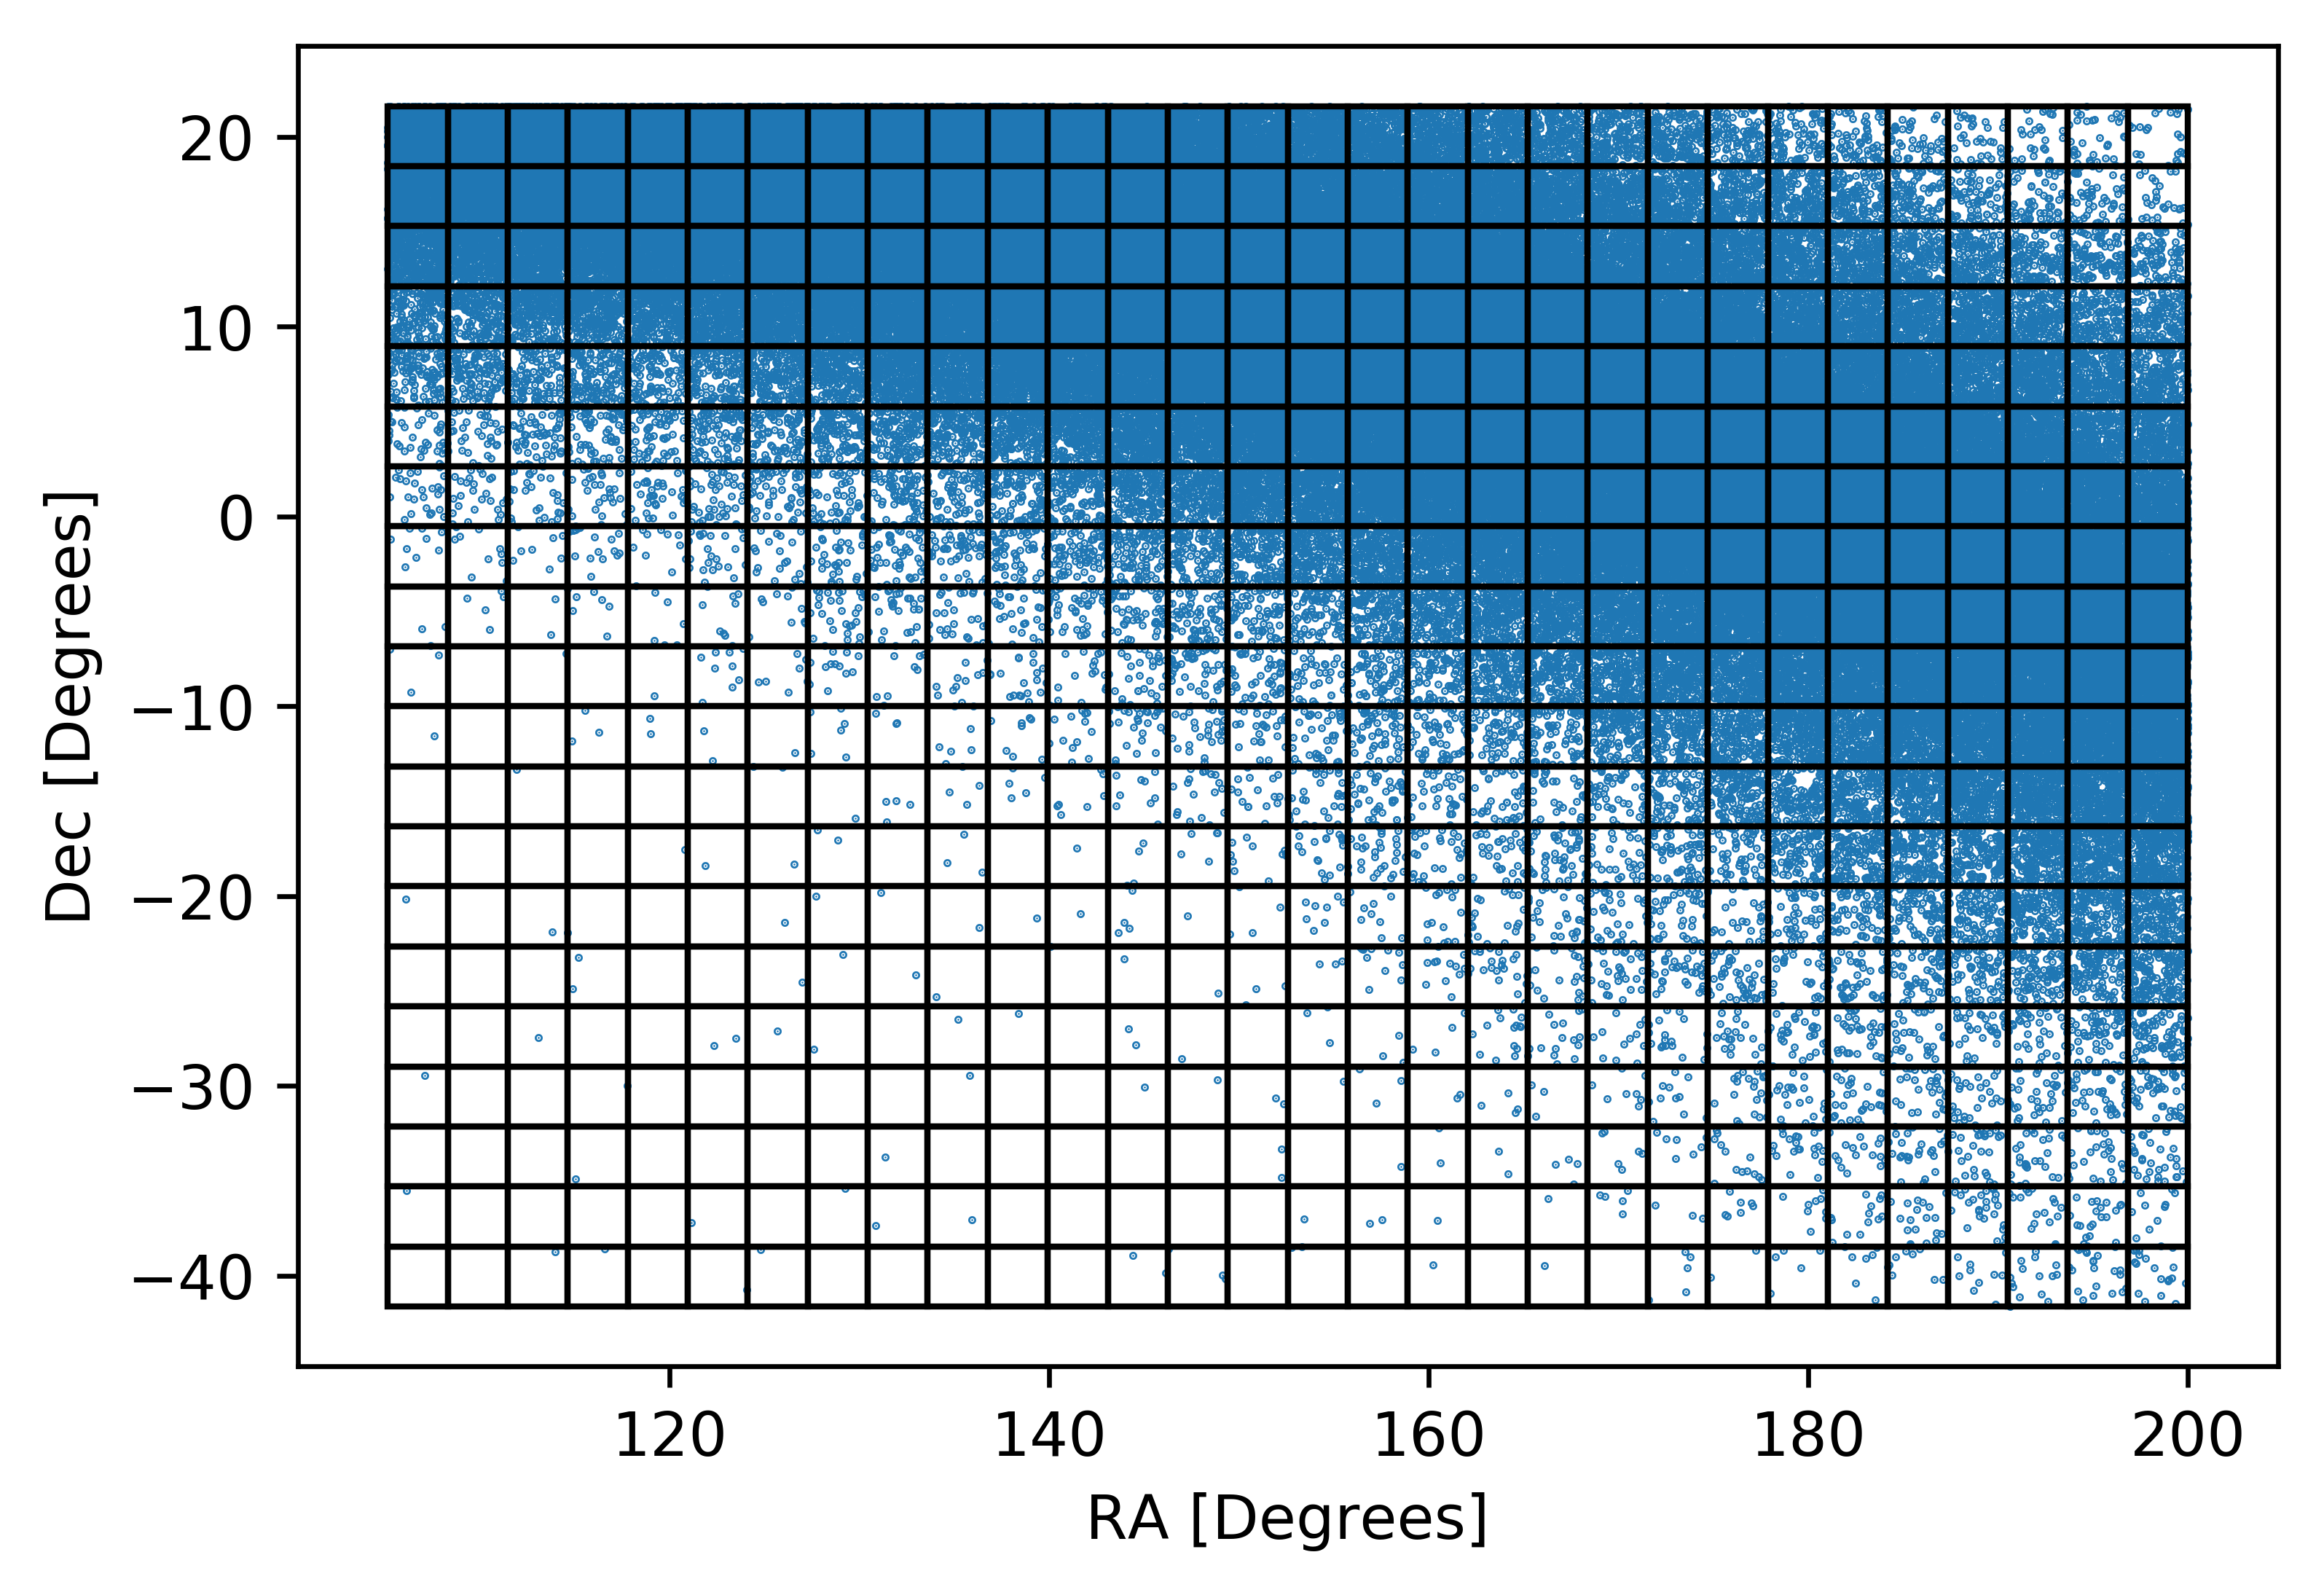

In [13]:
# Plot footprint
fieldArea = 10
xField = np.sqrt(fieldArea)
yField = np.sqrt(fieldArea)

fig, ax = plt.subplots(1, 1, dpi=600)
ax.set_xlabel("RA [Degrees]", fontsize=10)
ax.set_ylabel("Dec [Degrees]", fontsize=10)
fields = [405, 406, 407, 408, 433, 434, 435, 436, 445, 446, 447, 448, 473, 474, 475, 476]
for xx, yy in zip(survey[(survey["night"] == survey["night"].min())]["fieldRA_deg"].values, 
                  survey[(survey["night"] == survey["night"].min())]["fieldDec_deg"].values):
    ax.add_patch(patches.Rectangle((xx-xField/2, yy-yField/2), xField, yField, fill=False, lw=1))
ax.scatter(observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["RA_deg"].values, 
           observations[(observations["night"] == survey["night"].min()) & (observations["designation"] != "NS")]["Dec_deg"].values,
           s=0.1)
ax.set_aspect("equal")
#fig.savefig("../poster/survey_4x4.png")

In [1]:
projected_obs, average_obj = runRangeAndShiftOnVisit(observations, 
                        434, 
                        None,
                        None,
                        useAverageObject=True,
                        searchArea=1,
                        cellArea=1,
                        verbose=False,
                        )

NameError: name 'runRangeAndShiftOnVisit' is not defined

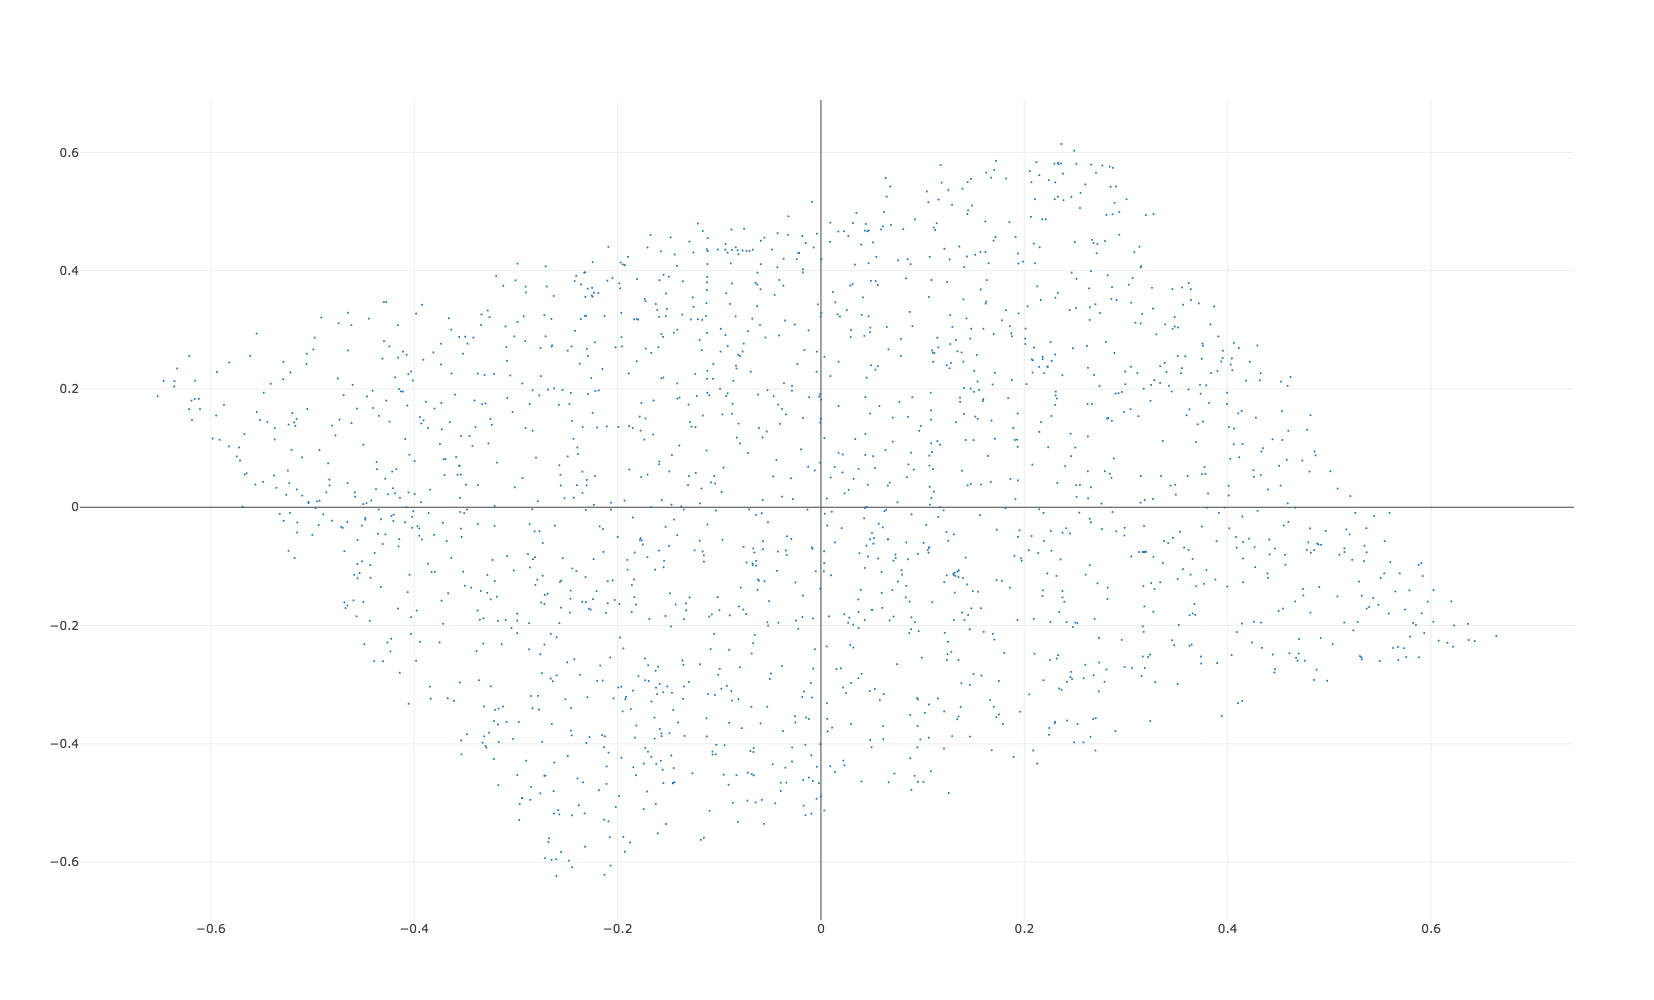

In [15]:
fig = plotProjections(projected_obs)

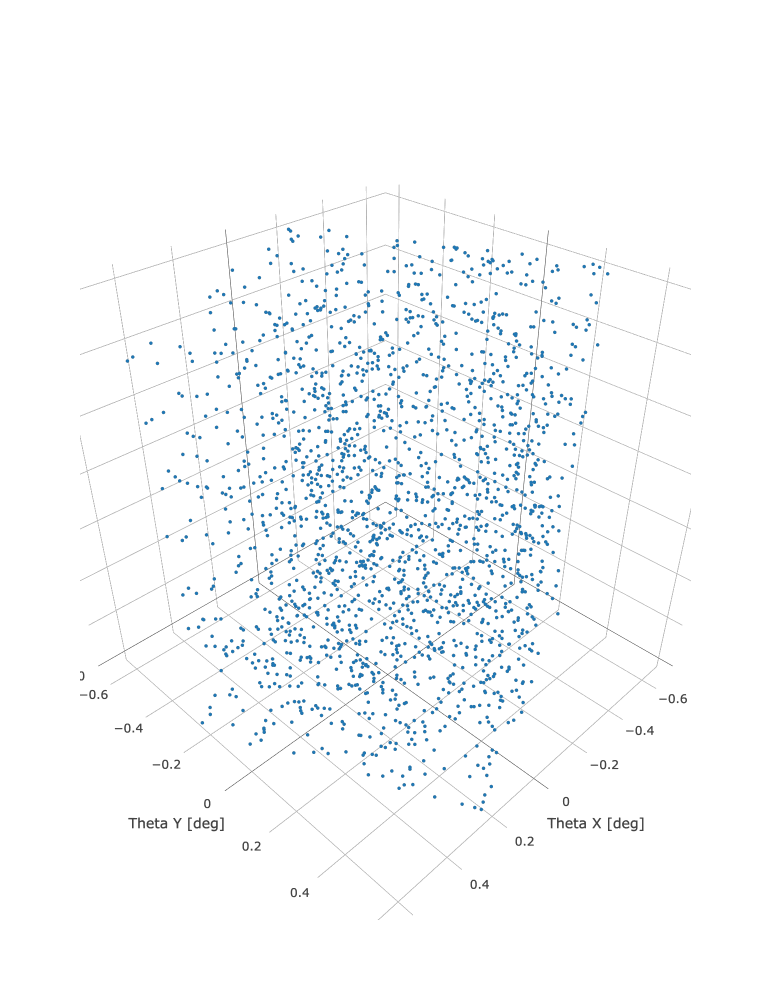

In [16]:
fig = plotProjections3D(projected_obs)

## Analyze Observations

In [16]:
allObjects_survey, summary_survey = analyzeObservations(observations)

THOR: analyzeObservations
-------------------------
Analyzing observations...
Object observations: 2525712
Noise observations: 9004333
Observation contamination (%): 78.0945174108167
Unique objects: 342249
Unique objects with at least 5 detections: 329759

Total time in seconds: 19.768754243850708
-------------------------



In [21]:
import pyoorb

In [22]:
pyoorb.pyoorb.element_types

array(b'cartes', dtype='|S6')

(0.0, 6)

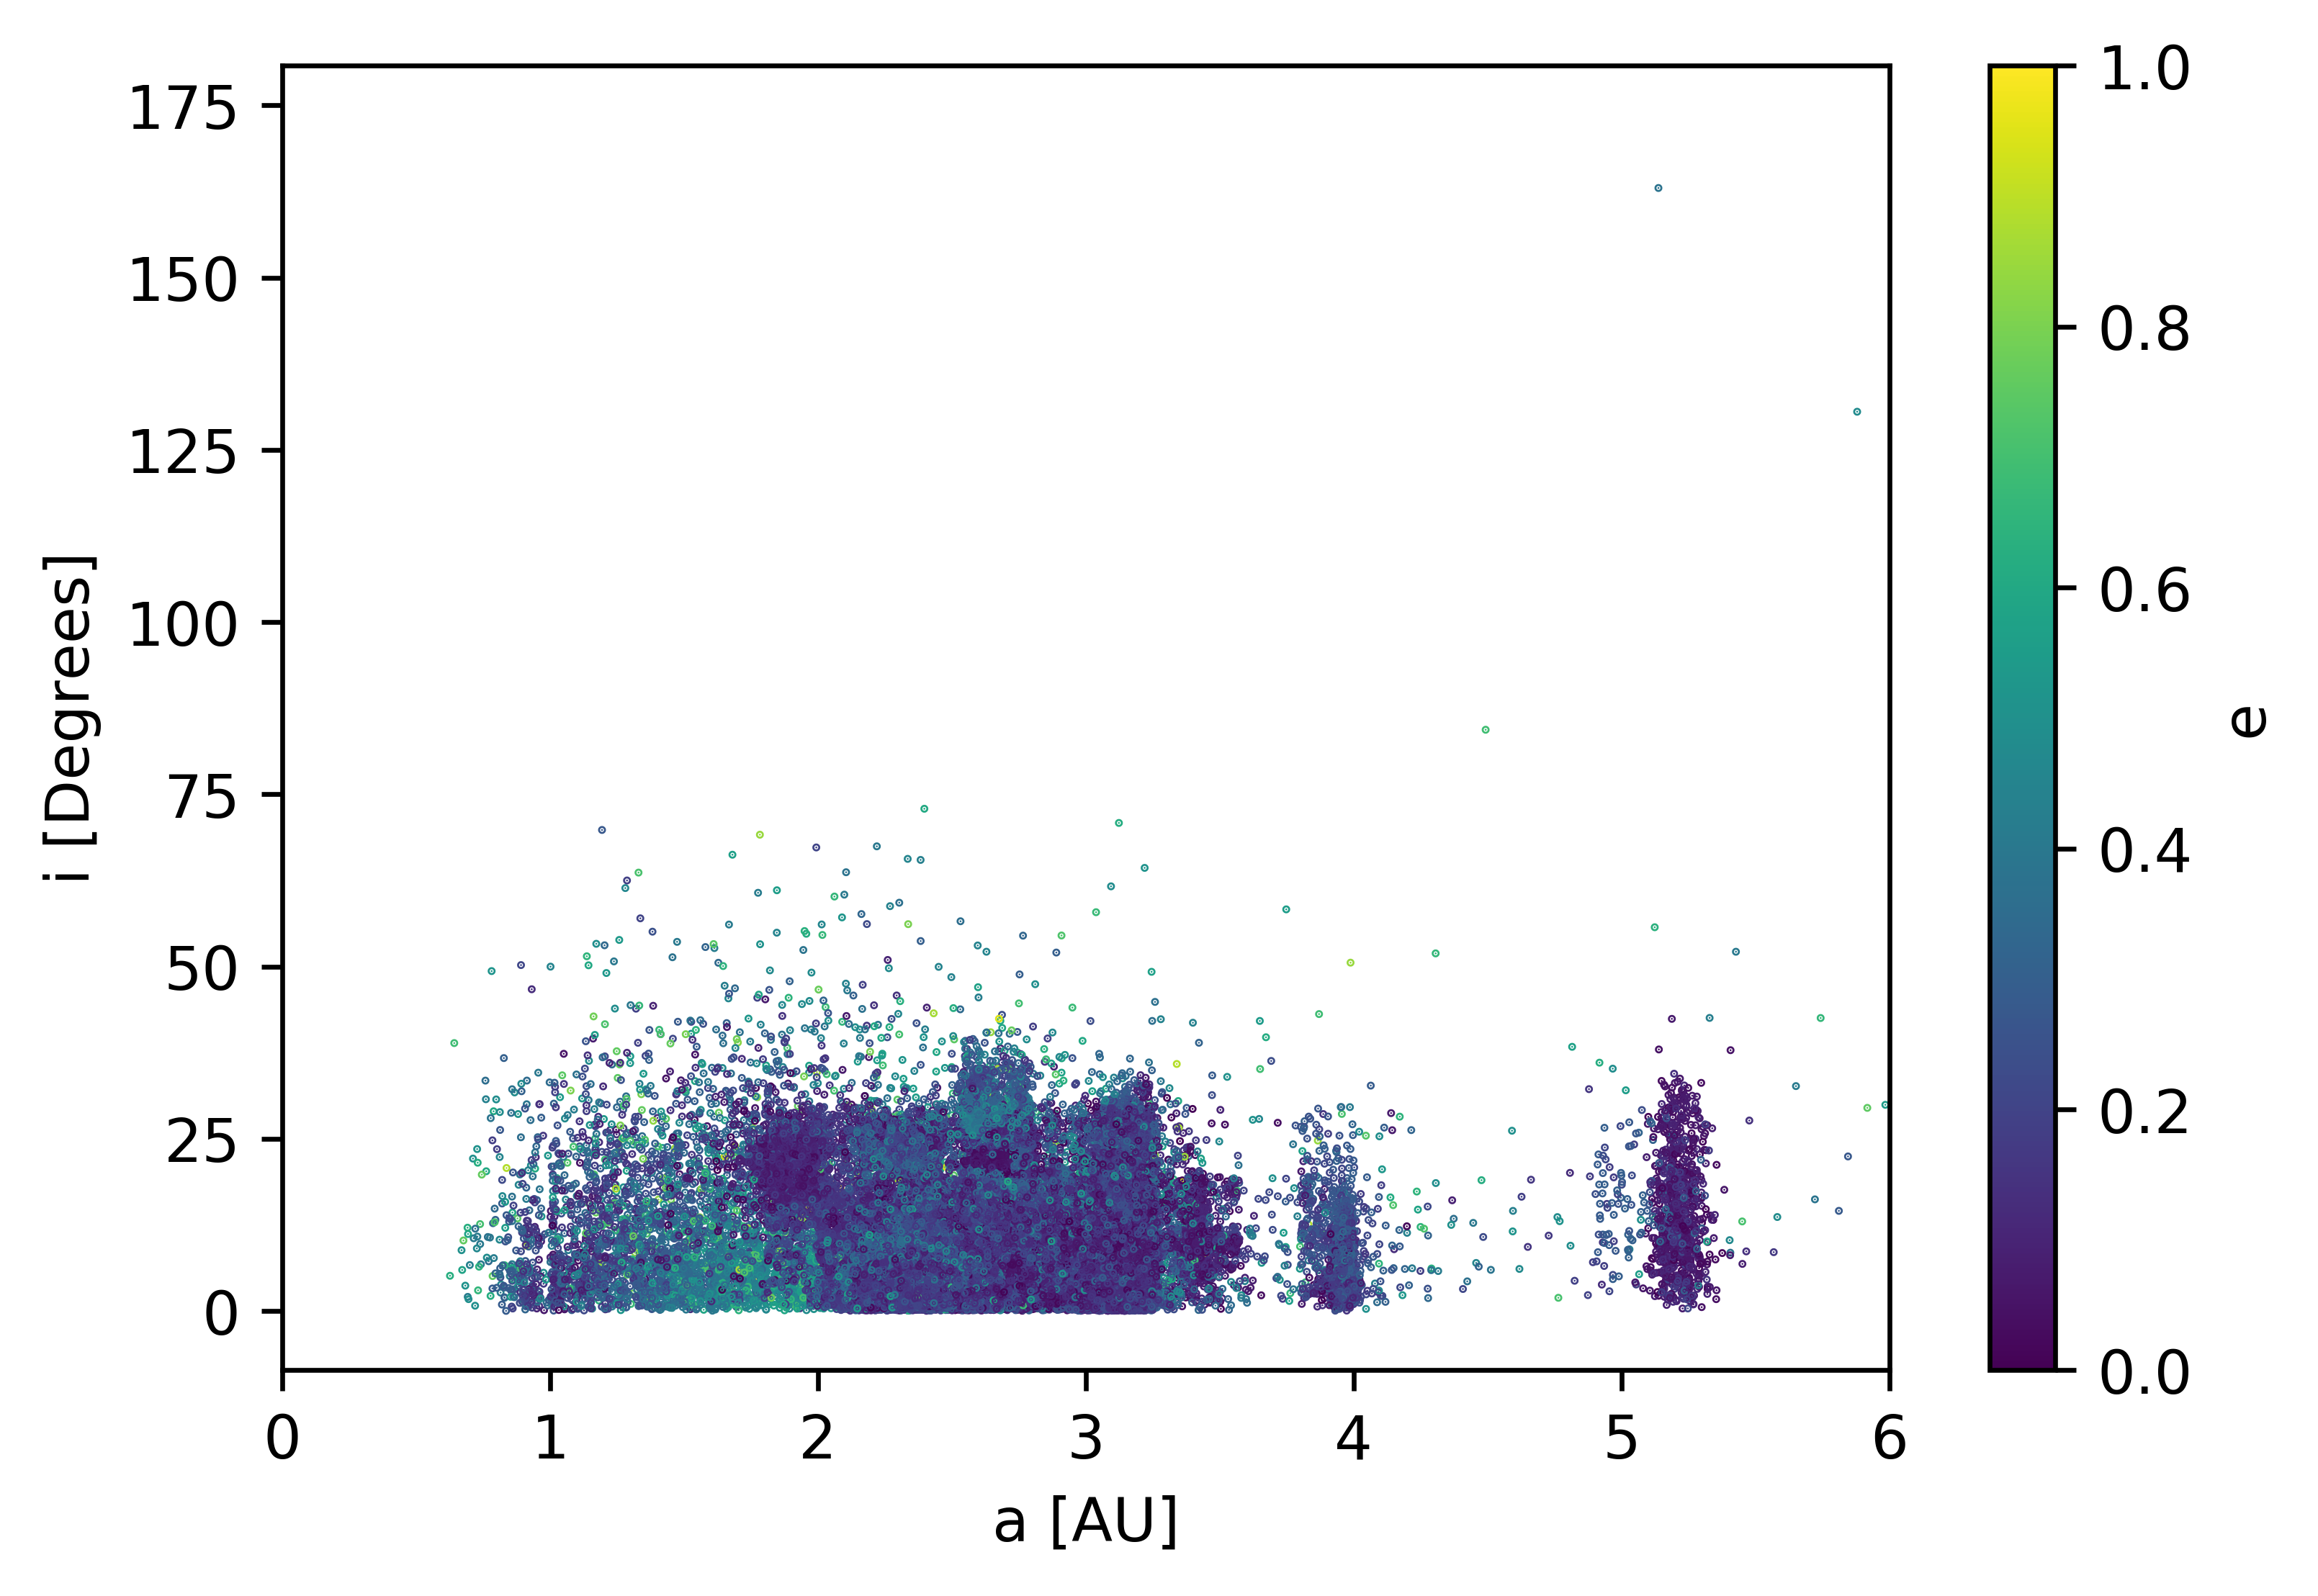

In [20]:
fig, ax = plotOrbitsFindable(allObjects_survey, orbits)
ax.set_xlim(0.0, 6)
#ax.set_ylim(0, 50)
#ax.text(0.55, 47, "Findable Objects: {}".format(len(allObjects_survey[allObjects_survey["findable"] == 1])), size=10)
#fig.savefig("../analysis/msst405_4x4/findable_orbits.png")

## Range and Shift

In [23]:
findAverageObject(observations[(observations["visitId"] == 434)])

THOR: findAverageObject
-------------------------
A1076 is the most average object.
-------------------------



'A1076'

In [23]:
from thor import Config

In [44]:
average = observations[(observations["visitId"] == 434) & (observations["r_au"] <= 2.3) & (observations["designation"] == "L5018")]

In [25]:
projected_obs = projected_obs = runRangeAndShiftOnVisit(observations, 
                        434, 
                        None,
                        None,
                        useAverageObject=True,
                        searchArea=10,
                        cellArea=1000,
                        verbose=False,
                        )

THOR: findAverageObject
-------------------------
A1076 is the most average object.
-------------------------



In [28]:
projected_obs[1].to_csv("../analysis/msst/average_obj_434_A1076.txt", sep=" ", index=False)

In [39]:
allObjects_projection, summary_projection = analyzeProjections(projected_obs)

THOR: analyzeProjections
-------------------------
Analyzing projections...
Object observations: 85925
Noise observations: 64918
Observation contamination (%): 43.03679985150123
Unique objects: 13076
Unique objects with at least 5 detections: 10880

Total time in seconds: 362.91800117492676
-------------------------



In [82]:
projected_obs = pd.read_csv("../analysis/msst405_4x4_epyc/visit_405/projected_obs_clustering.txt", sep=" ", index_col=False)

In [ ]:
plotProjections(projected_obs)

In [41]:
projected_obs.to_csv("../analysis/msst405_4x4/visit_434_circular/projected_obs.txt", sep=" ", index=False)

In [42]:
allObjects_projection.to_csv("../analysis/msst405_4x4/visit_434_circular/allObjects_projections.txt", sep=" ", index=False)

In [45]:
average.to_csv("../analysis/msst405_4x4/visit_434_circular/average_obj.txt", sep=" ", index=False)

In [48]:
summary_projection.to_csv("../analysis/msst405_4x4/visit_434_circular/summary_projection.txt", sep=" ", index=False)

(<Figure size 3600x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1b05f37a90>)

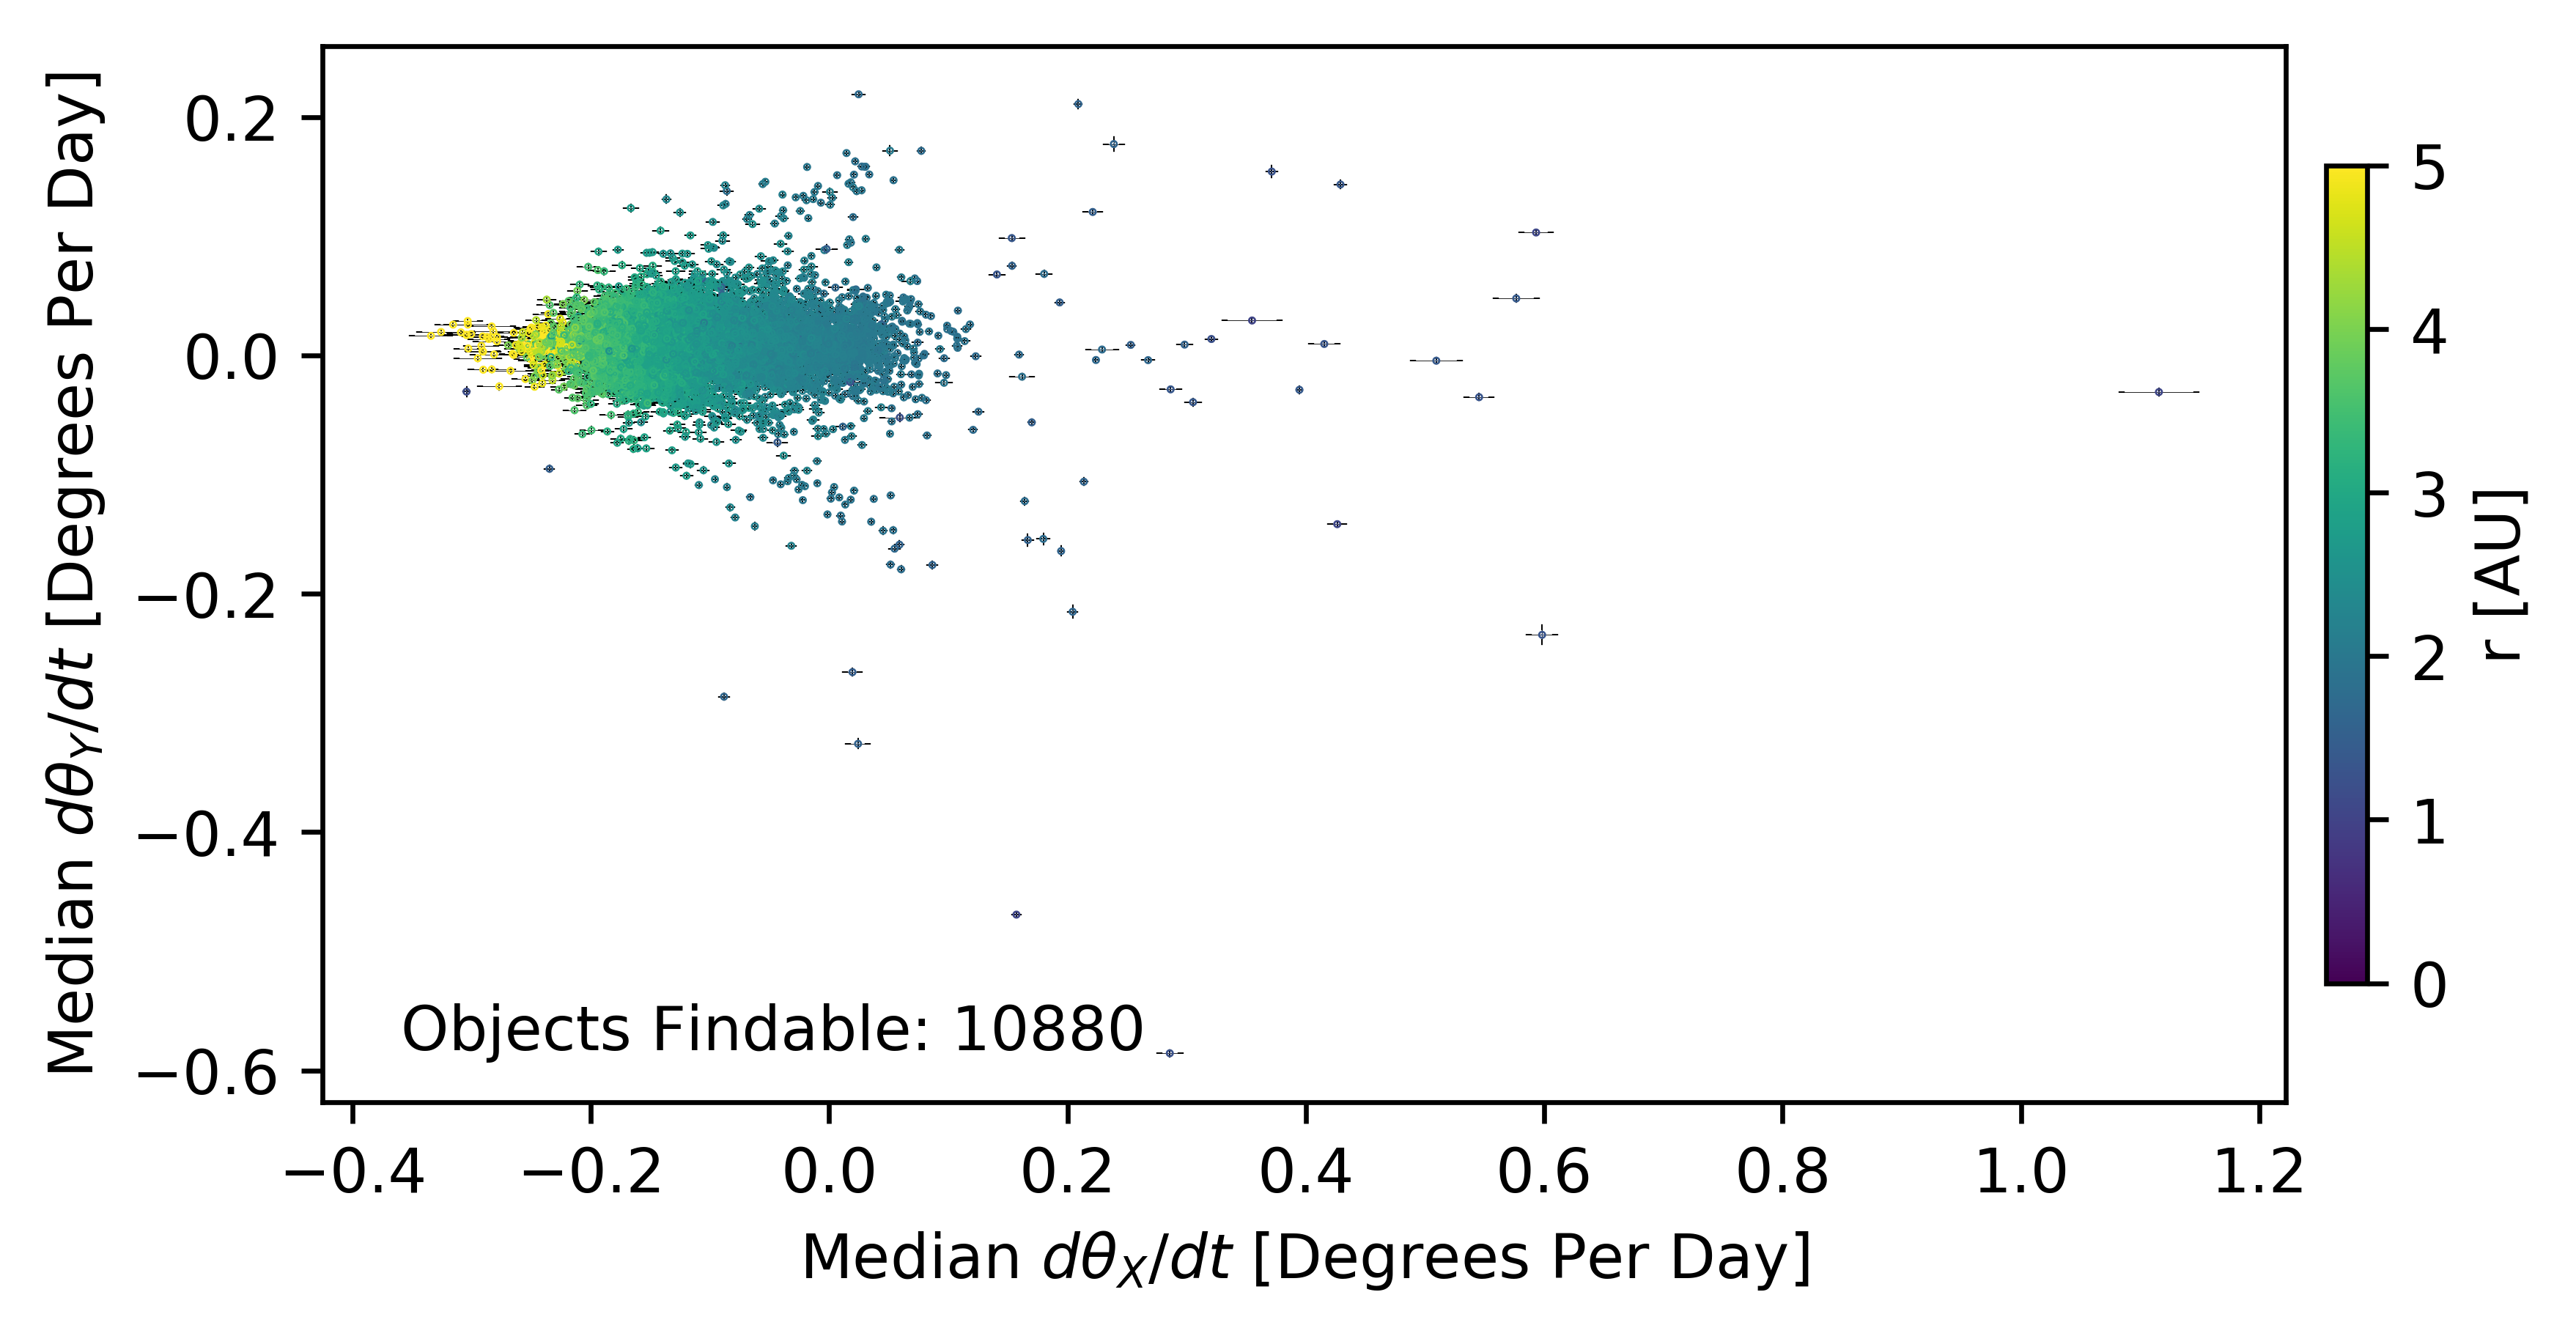

In [40]:
plotProjectionVelocitiesFindable(allObjects_projection)

In [51]:
for visit in fields:
    os.mkdir("../analysis/msst405_4x4/visit_{}".format(visit))
    projected_obs, average = runRangeAndShiftOnVisit(observations, 
                             visit, 
                             2.3,
                             None,
                             useAverageObject=True,
                             searchArea=10,
                             cellArea=100,
                             verbose=False,
                             saveFiles=["../analysis/msst405_4x4/visit_{}/projected_obs_c.txt".format(visit),
                                        "../analysis/msst405_4x4/visit_{}/average_obj_c.txt".format(visit)])

THOR: findAverageObject
-------------------------
c3020 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
K08Y95U is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
V2276 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
A9558 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
G3776 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
A1076 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
K13Q27Z is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
d5428 is the most average object.
-------------------------

THOR: findAverageObject
-------------------------
U2749 is the most average object.
------------------------

In [24]:
allObjects_visit = analyzeVisit(observations, 405)

THOR: analyzeVisit
-------------------------
Analyzing visit 405...
Object observations in visit: 1443
Noise observations in visit: 970
Observation contamination (%): 40.198922503108165
Unique objects in visit: 1443
Unique objects with at least 5 detections in survey: 1443

Total time in seconds: 0.10532832145690918
-------------------------



### Analyze Projections

In [25]:
allObjects_projection, summary_projection = analyzeProjections(projected_obs)

THOR: analyzeProjections
-------------------------
Analyzing projections...
Object observations: 69618
Noise observations: 45709
Observation contamination (%): 39.634257372514675
Unique objects: 12107
Unique objects with at least 5 detections: 8077

Total time in seconds: 277.3862018585205
-------------------------



In [27]:
vxRange=[-0.1, 0.1]
vyRange=[-0.1, 0.1]

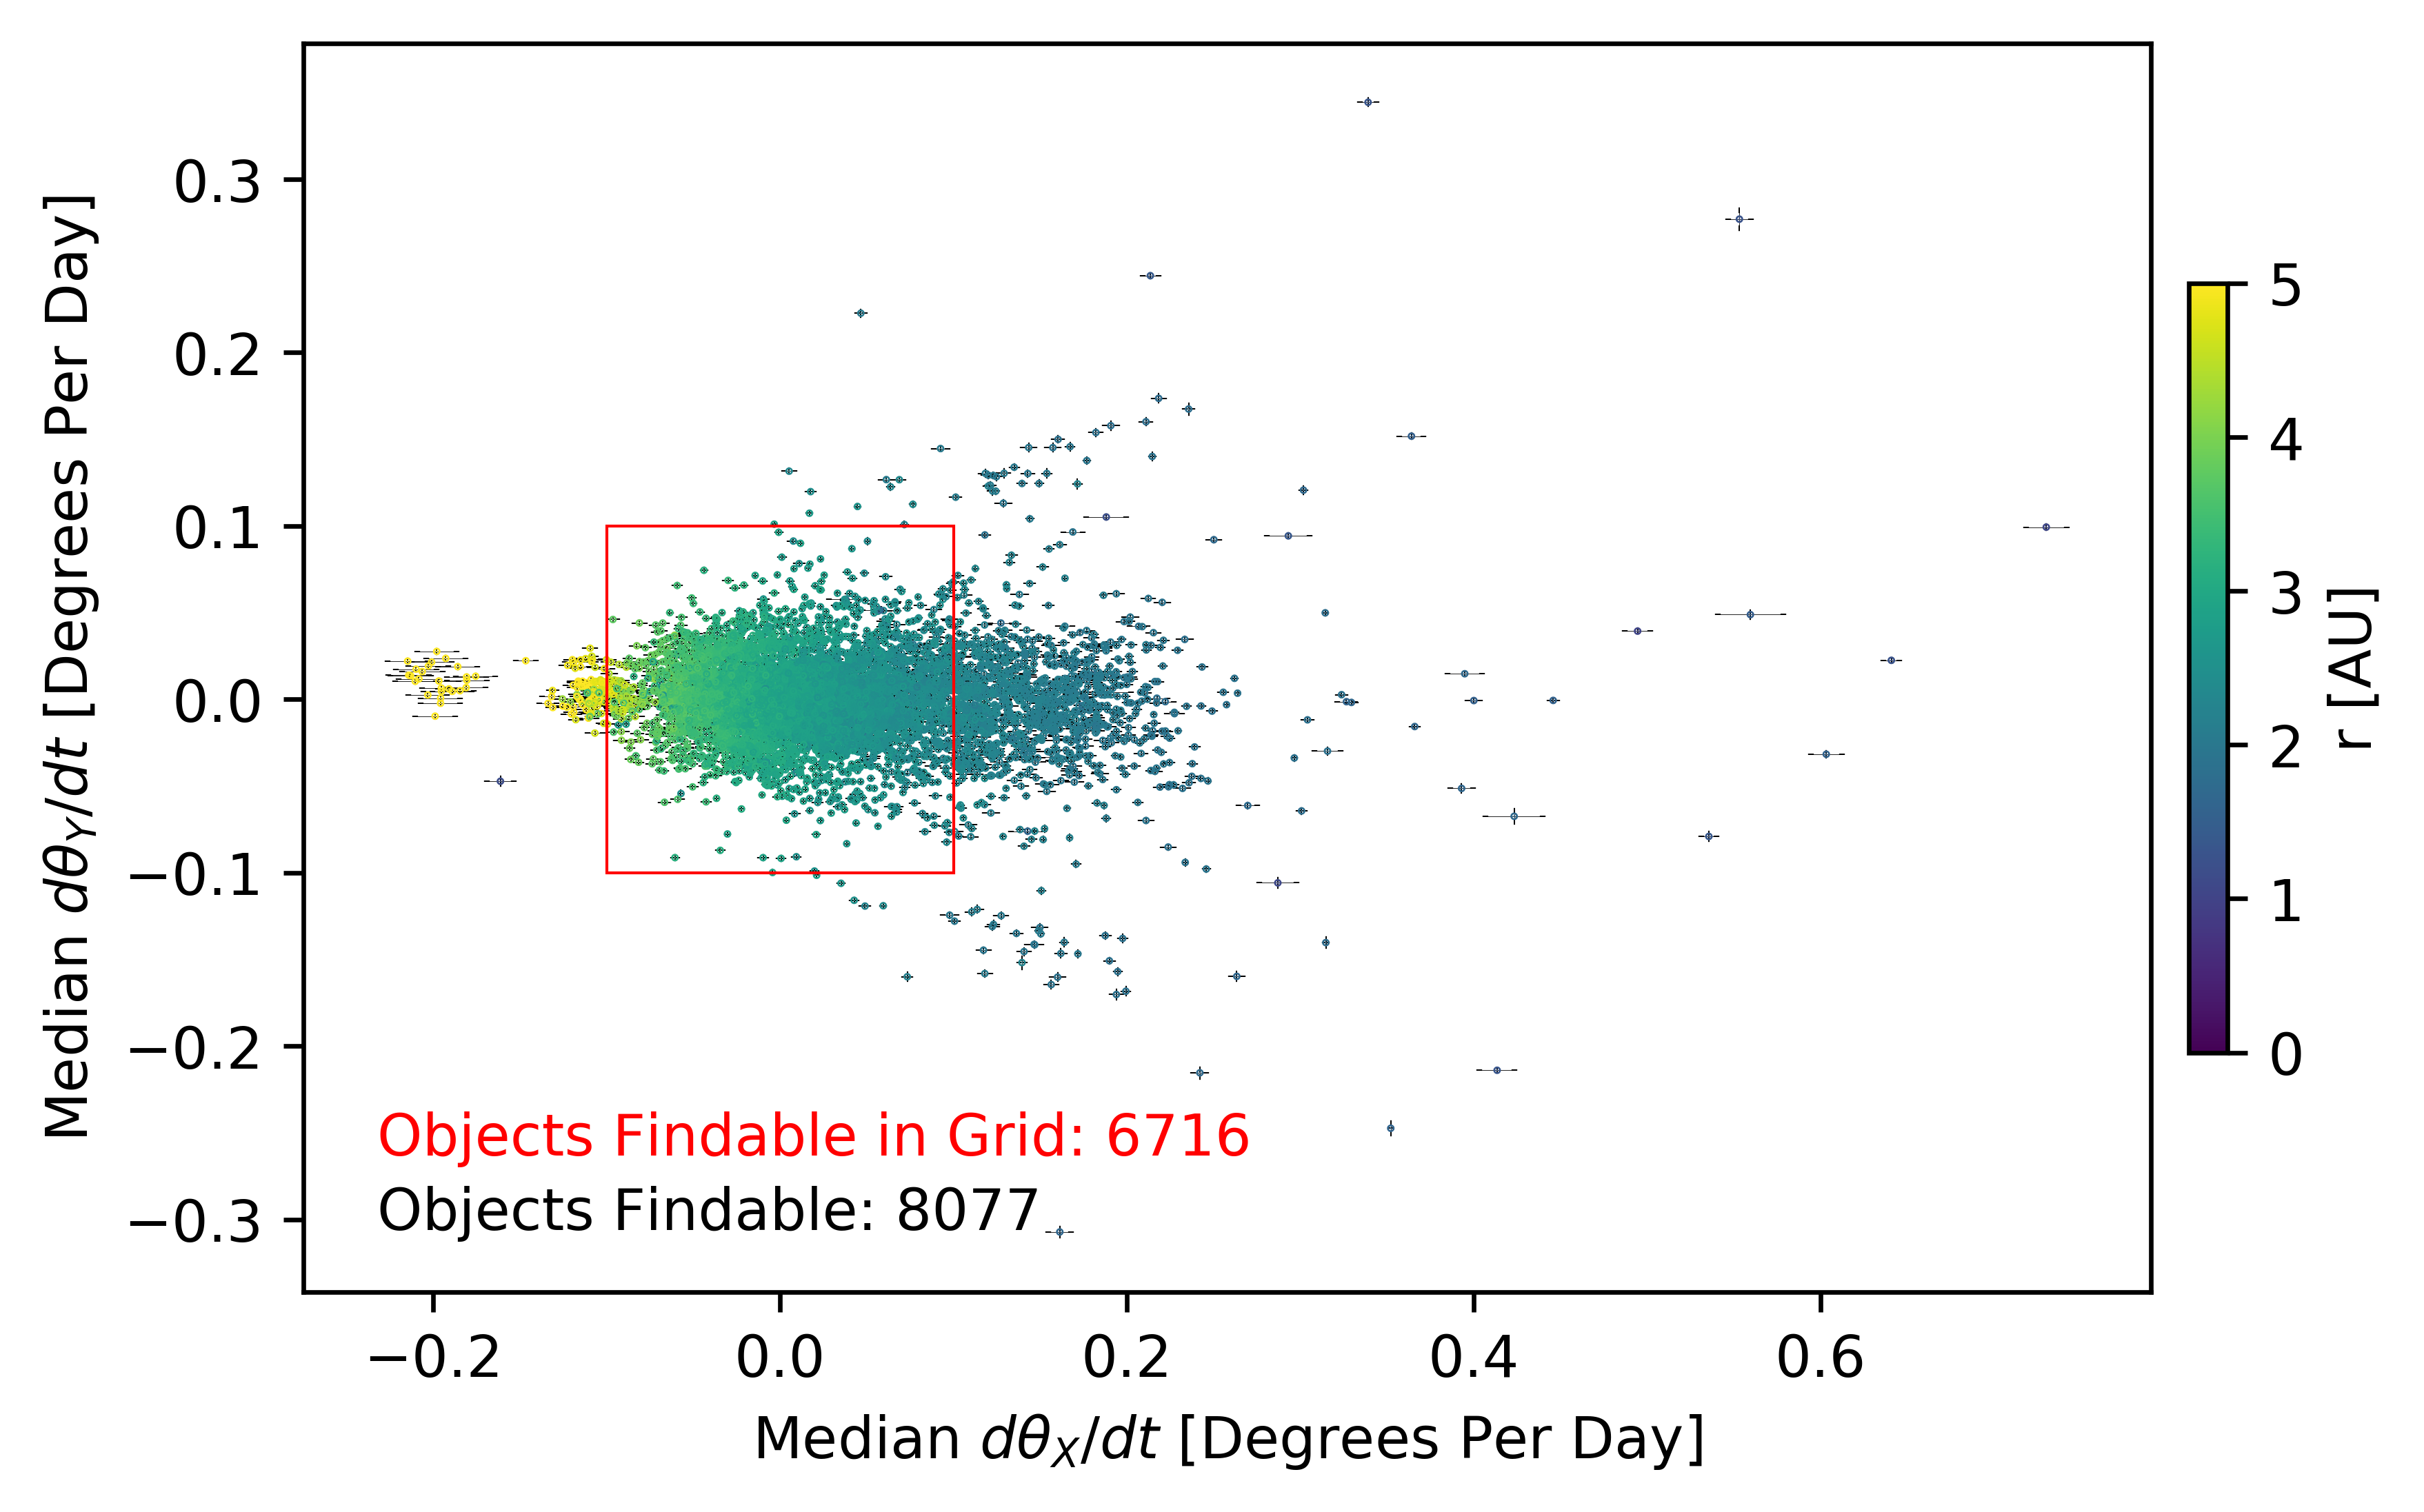

In [28]:
fig, ax = plotProjectionVelocitiesFindable(allObjects_projection, vxRange=vxRange, vyRange=vyRange)

In [34]:
allObjects_projection["found_pure"] = np.NaN * np.ones(len(allObjects_projection))
allObjects_projection["found_partial"] = np.NaN * np.ones(len(allObjects_projection))
allObjects_projection["found"] = np.NaN * np.ones(len(allObjects_projection))

In [37]:
allClusters_projection, clusterMembers_projection = clusterAndLink(
        projected_obs, 
        eps=0.005,
        minSamples=5, 
        vxRange=vxRange, 
        vyRange=vyRange,
        vxBins=20,
        vyBins=20,
        threads=6)

THOR: clusterAndLink
-------------------------
Running velocity space clustering...
X velocity range: [-0.1, 0.1]
X velocity bins: 20
Y velocity range: [-0.1, 0.1]
Y velocity bins: 20
User defined x velocity values: False
User defined y velocity values: False
Velocity grid size: 400
Max sample distance: 0.005
Minimum samples: 5
Using 6 threads...
Done. Completed in 61.25890612602234 seconds.

Restructuring clusters...
Done. Completed in 0.03400588035583496 seconds.

Found 1136 clusters.
Total time in seconds: 61.293251037597656
-------------------------



In [38]:
allClusters_projection, clusterMembers_projection, allObjects_projection, summary_projection = analyzeClusters(
        projected_obs,
        allClusters_projection, 
        clusterMembers_projection, 
        allObjects_projection,
        summary_projection,
        contaminationThreshold=0.2,
        minSamples=5)

THOR: analyzeClusters
-------------------------
Analyzing clusters...
Pure clusters: 242
Partial clusters: 85
Duplicate visit clusters: 718
False clusters: 809
Total clusters: 1136
Cluster contamination (%): 71.21478873239437
Unique linked objects: 327
Unique missed objects: 7750
Completeness (%): 4.048532871115513
Done.
Total time in seconds: 0.35199713706970215
-------------------------



In [82]:
def grabLinkedDetections(observations, allClusters, clusterMembers):
    # Grab pure cluster obs_ids
    pure_clusters = allClusters[allClusters["pure"] == 1]["cluster_id"].values
    pure_obs_ids_linked = clusterMembers[clusterMembers["cluster_id"].isin(pure_clusters)]["obs_id"].values

    partial_clusters = allClusters[allClusters["partial"] == 1]["cluster_id"].values
    cluster_designation = clusterMembers[clusterMembers["cluster_id"].isin(partial_clusters)].merge(observations[["obsId", "designation"]], 
                                                                                                    left_on="obs_id", 
                                                                                                    right_on="obsId")
    cluster_designation = cluster_designation.merge(allClusters[["cluster_id", "linked_object"]])
    partial_obs_ids_linked = cluster_designation[cluster_designation["designation"] == cluster_designation["linked_object"]]["obs_id"].values
    
    linked_obs_ids = np.concatenate([pure_obs_ids_linked, partial_obs_ids_linked])
    return np.unique(linked_obs_ids)

In [83]:
linked_obs_ids = grabLinkedDetections(projected_obs, allClusters_projection, clusterMembers_projection)

In [88]:
linked_objects = np.unique(projected_obs[projected_obs["obsId"].isin(linked_obs_ids)]["designation"].values)

In [96]:
linked_objects.sort() == ll.sort()

True

In [93]:
ll = allObjects_projection[allObjects_projection["found"] == 1]["designation"].values

array([ 131350,  455997,  782190, 1111395, 1443587, 1778699, 2116928,
        139220,  462761,  789106, 1123535, 1455844,  452701,  778820,
       1107939, 1451135, 1786375,  140014,  463579,  788590, 1117891,
       1450181,  779212, 1108347, 1440466, 1775481, 2113576,  130765,
        454168,  780342, 1109499, 1441647, 1107821, 1439930, 1774946,
       2113052, 2454271,  130986,  454415,  788268, 1117565, 1449822,
       1785017, 2123293,  131485,  454922,  781107, 1110275, 1442456,
        780703, 1109859, 1449945, 1785142, 2121771, 2463071,  130833,
        454244,  788106, 1117401, 1449655,  139518,  463064,  789437,
       1118741, 1451038, 1786275, 2129743, 2471110,  453268,  781040,
       1110202, 1442377, 1777445, 1117900, 1450190, 1785396, 2123667,
       2464997,  452259,  778381, 1107476, 1439580, 1786018, 2122553,
       2463886, 1109649, 1441796, 1776854, 2115033, 2456280,  452991,
        779128, 1108268, 1440388, 1775402, 2124930, 2466258, 1108726,
       1442615, 1777

In [67]:
p

cluster_id    obs_id     obsId designation
0           153    131350    131350     K12L13X
1           153    455997    455997     K12L13X
2           153    782190    782190     K12L13X
3           153   1111395   1111395     K12L13X
4           153   1443587   1443587     K12L13X
5           153   1442947   1442947       G4040
6           153   1778699   1778699     K12L13X
7           153   2116928   2116928     K12L13X
8           167    139220    139220       72016
9           167    462761    462761       72016
10          167    789106    789106       72016
11          167    789389    789389       M4337
12          167   1123535   1123535       72016
13          167   1455844   1455844       72016
14          191    452701    452701       U0624
15          191    778820    778820       U0624
16          191   1107939   1107939       U0624
17          191   1451135   1451135       U0624
18          191   1786375   1786375       U0624
19          191  11366170  11366170          NS
20          269    140014    140014     K09V13X
21          269    463579    463579     K09V13X
22          269    788590    788590     K09V13X
23          269   1117891   1117891     K09V13X
24          269   1117199   1117199       M1876
25          269   1450181   1450181     K09V13X
26          287    129042    129042       H5632
27          287    779212    779212       n3074
28          287   1108347   1108347       n3074
29          287   1440466   1440466       n3074
..          ...       ...       ...         ...
578         895    454950    454950     K01FM5L
579         895    781134    781134     K01FM5L
580         895   1110300   1110300     K01FM5L
581         895   1442484   1442484     K01FM5L
582         895   1777557   1777557     K01FM5L
583         895   1777710   1777710     K13T95M
584         895   2115777   2115777     K01FM5L
585         895   2465189   2465189     K01FM5L
586         931    779601    779601     K14OJ7Y
587         931   1108751   1108751     K14OJ7Y
588         931   1451787   1451787     K14OJ7Y
589         931   1787014   1787014     K14OJ7Y
590         931   2125327   2125327     K14OJ7Y
591         931   2466669   2466669     K14OJ7Y
592         931  11366350  11366350          NS
593         936    140157    140157     K01SX2S
594         936    463723    463723     K01SX2S
595         936    462833    462833       B3613
596         936    790105    790105     K01SX2S
597         936   1119416   1119416     K01SX2S
598         936   1451699   1451699     K01SX2S
599         936   1786930   1786930     K01SX2S
600         936   2129045   2129045     K01SX2S
601         936   2470395   2470395     K01SX2S
602         952   1110412   1110412     K11HA0H
603         952   1441523   1441523       M4223
604         952   1442604   1442604     K11HA0H
605         952   1777675   1777675     K11HA0H
606         952   2117132   2117132     K11HA0H
607         952   2458420   2458420     K11HA0H

[608 rows x 4 columns]

cluster_id    obs_id     obsId designation linked_object
0           153    131350    131350     K12L13X       K12L13X
1           153    455997    455997     K12L13X       K12L13X
2           153    782190    782190     K12L13X       K12L13X
3           153   1111395   1111395     K12L13X       K12L13X
4           153   1443587   1443587     K12L13X       K12L13X
5           153   1442947   1442947       G4040       K12L13X
6           153   1778699   1778699     K12L13X       K12L13X
7           153   2116928   2116928     K12L13X       K12L13X
8           167    139220    139220       72016         72016
9           167    462761    462761       72016         72016
10          167    789106    789106       72016         72016
11          167    789389    789389       M4337         72016
12          167   1123535   1123535       72016         72016
13          167   1455844   1455844       72016         72016
14          191    452701    452701       U0624         U0624
15          191    778820    778820       U0624         U0624
16          191   1107939   1107939       U0624         U0624
17          191   1451135   1451135       U0624         U0624
18          191   1786375   1786375       U0624         U0624
19          191  11366170  11366170          NS         U0624
20          269    140014    140014     K09V13X       K09V13X
21          269    463579    463579     K09V13X       K09V13X
22          269    788590    788590     K09V13X       K09V13X
23          269   1117891   1117891     K09V13X       K09V13X
24          269   1117199   1117199       M1876       K09V13X
25          269   1450181   1450181     K09V13X       K09V13X
26          287    129042    129042       H5632         n3074
27          287    779212    779212       n3074         n3074
28          287   1108347   1108347       n3074         n3074
29          287   1440466   1440466       n3074         n3074
..          ...       ...       ...         ...           ...
578         895    454950    454950     K01FM5L       K01FM5L
579         895    781134    781134     K01FM5L       K01FM5L
580         895   1110300   1110300     K01FM5L       K01FM5L
581         895   1442484   1442484     K01FM5L       K01FM5L
582         895   1777557   1777557     K01FM5L       K01FM5L
583         895   1777710   1777710     K13T95M       K01FM5L
584         895   2115777   2115777     K01FM5L       K01FM5L
585         895   2465189   2465189     K01FM5L       K01FM5L
586         931    779601    779601     K14OJ7Y       K14OJ7Y
587         931   1108751   1108751     K14OJ7Y       K14OJ7Y
588         931   1451787   1451787     K14OJ7Y       K14OJ7Y
589         931   1787014   1787014     K14OJ7Y       K14OJ7Y
590         931   2125327   2125327     K14OJ7Y       K14OJ7Y
591         931   2466669   2466669     K14OJ7Y       K14OJ7Y
592         931  11366350  11366350          NS       K14OJ7Y
593         936    140157    140157     K01SX2S       K01SX2S
594         936    463723    463723     K01SX2S       K01SX2S
595         936    462833    462833       B3613       K01SX2S
596         936    790105    790105     K01SX2S       K01SX2S
597         936   1119416   1119416     K01SX2S       K01SX2S
598         936   1451699   1451699     K01SX2S       K01SX2S
599         936   1786930   1786930     K01SX2S       K01SX2S
600         936   2129045   2129045     K01SX2S       K01SX2S
601         936   2470395   2470395     K01SX2S       K01SX2S
602         952   1110412   1110412     K11HA0H       K11HA0H
603         952   1441523   1441523       M4223       K11HA0H
604         952   1442604   1442604     K11HA0H       K11HA0H
605         952   1777675   1777675     K11HA0H       K11HA0H
606         952   2117132   2117132     K11HA0H       K11HA0H
607         952   2458420   2458420     K11HA0H       K11HA0H

[608 rows x 5 columns]

In [61]:
projected_obs

obsId  visitId  fieldId  fieldRA_deg  fieldDec_deg       exp_mjd  \
2931121    2933184      405      405   169.958362      7.392527  59740.218056   
129319      129465      405      405   169.958362      7.392527  59740.218056   
129318      129464      405      405   169.958362      7.392527  59740.218056   
129317      129463      405      405   169.958362      7.392527  59740.218056   
129316      129462      405      405   169.958362      7.392527  59740.218056   
129315      129461      405      405   169.958362      7.392527  59740.218056   
129314      129460      405      405   169.958362      7.392527  59740.218056   
129320      129466      405      405   169.958362      7.392527  59740.218056   
129313      129459      405      405   169.958362      7.392527  59740.218056   
129311      129457      405      405   169.958362      7.392527  59740.218056   
129310      129456      405      405   169.958362      7.392527  59740.218056   
129309      129455      405      405   169.958362      7.392527  59740.218056   
129308      129454      405      405   169.958362      7.392527  59740.218056   
129307      129453      405      405   169.958362      7.392527  59740.218056   
129306      129452      405      405   169.958362      7.392527  59740.218056   
129312      129458      405      405   169.958362      7.392527  59740.218056   
129321      129467      405      405   169.958362      7.392527  59740.218056   
129322      129468      405      405   169.958362      7.392527  59740.218056   
129323      129469      405      405   169.958362      7.392527  59740.218056   
129338      129484      405      405   169.958362      7.392527  59740.218056   
129337      129483      405      405   169.958362      7.392527  59740.218056   
129336      129482      405      405   169.958362      7.392527  59740.218056   
129335      129481      405      405   169.958362      7.392527  59740.218056   
129334      129480      405      405   169.958362      7.392527  59740.218056   
129333      129479      405      405   169.958362      7.392527  59740.218056   
129332      129478      405      405   169.958362      7.392527  59740.218056   
129331      129477      405      405   169.958362      7.392527  59740.218056   
129330      129476      405      405   169.958362      7.392527  59740.218056   
129329      129475      405      405   169.958362      7.392527  59740.218056   
129328      129474      405      405   169.958362      7.392527  59740.218056   
...            ...      ...      ...          ...           ...           ...   
11374562  11376625     8847      447   176.282918      1.067972  59754.247222   
11374563  11376626     8847      447   176.282918      1.067972  59754.247222   
11374564  11376627     8847      447   176.282918      1.067972  59754.247222   
11374565  11376628     8847      447   176.282918      1.067972  59754.247222   
11374568  11376631     8847      447   176.282918      1.067972  59754.247222   
11374570  11376633     8847      447   176.282918      1.067972  59754.247222   
11374576  11376639     8847      447   176.282918      1.067972  59754.247222   
11374578  11376641     8847      447   176.282918      1.067972  59754.247222   
2471849    2473867     8847      447   176.282918      1.067972  59754.247222   
2471846    2473864     8847      447   176.282918      1.067972  59754.247222   
2471844    2473862     8847      447   176.282918      1.067972  59754.247222   
2471842    2473860     8847      447   176.282918      1.067972  59754.247222   
2471809    2473827     8847      447   176.282918      1.067972  59754.247222   
2471810    2473828     8847      447   176.282918      1.067972  59754.247222   
2471815    2473833     8847      447   176.282918      1.067972  59754.247222   
2471817    2473835     8847      447   176.282918      1.067972  59754.247222   
2471818    2473836     8847      447   176.282918      1.067972  59754.247222   
2471820    2473838     8847      447   176.2

In [ ]:
clusterMembers_projection[clusterMembers_projection["cluster_id"].isin(pure_clusters)]

In [ ]:
calcLinkageEfficiency(allObjects_projection, vxRange=vxRange, vyRange=vyRange)

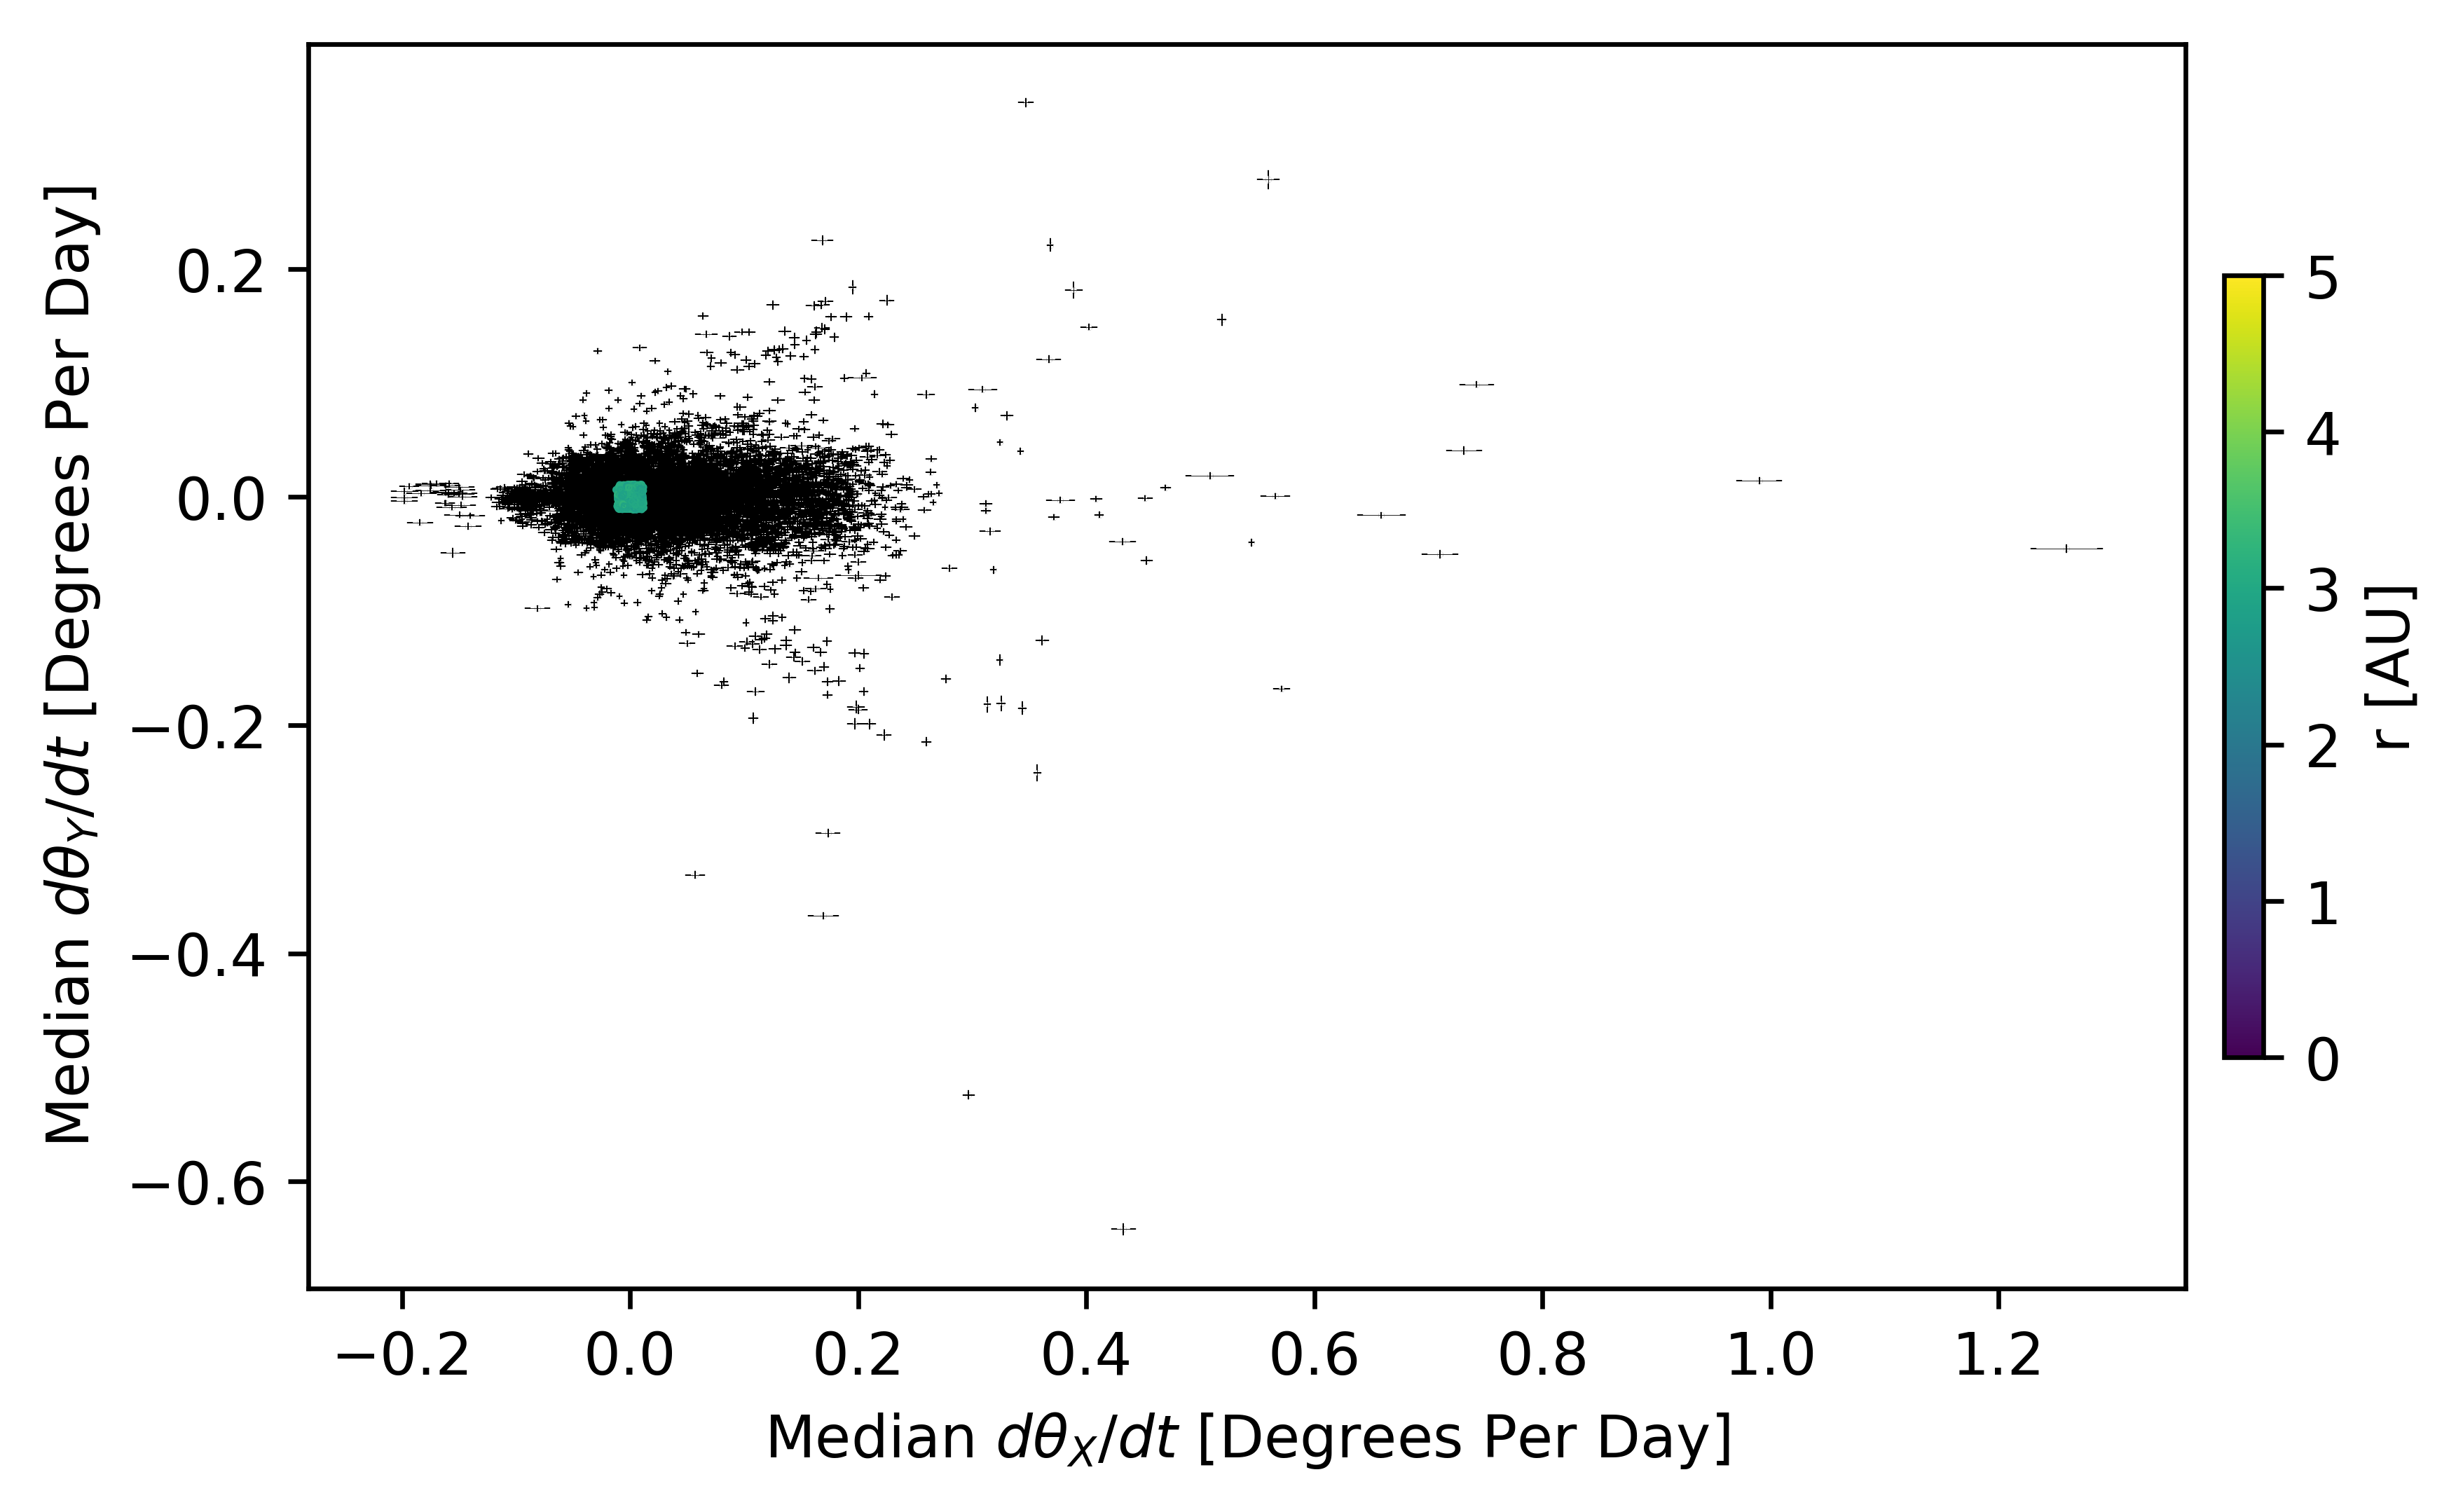

In [42]:
fig, ax = plotProjectionVelocitiesFound(allObjects_projection, vxRange=vxRange, vyRange=vyRange)

In [97]:
def runClusterAndLinkOnVisit(observations, 
                             visitId,
                             vxRange=[-0.1, 0.1], 
                             vyRange=[-0.1, 0.1],
                             vxBins=100, 
                             vyBins=100,
                             vxValues=None,
                             vyValues=None,
                             threads=6, 
                             eps=0.005, 
                             minSamples=5,
                             contaminationThreshold=0.2, 
                             saveDir=None,
                             verbose=True,
                             columnMapping=Config.columnMapping):
    """
    Parameters
    ----------
    observations : `~pandas.DataFrame`
        DataFrame containing post-range and shift observations.
    visitId : int
        Visit ID. 
    orbits : `~pandas.DataFrame`
        Orbit catalog.
    avgObject : `~pandas.DataFrame`
        A slice into the observations dataframe
        with the object's corresponding observation.
    vxRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in x. 
        Will not be used if vxValues are specified. 
        [Default = [-0.1, 0.1]]
    vxRange : {None, list or `~numpy.ndarray` (2)}
        Maximum and minimum velocity range in y. 
        Will not be used if vyValues are specified. 
        [Default = [-0.1, 0.1]]
    vxBins : int, optional
        Length of x-velocity grid between vxRange[0] 
        and vxRange[-1]. Will not be used if vxValues are 
        specified. 
        [Default = 100]
    vyBins: int, optional
        Length of y-velocity grid between vyRange[0] 
        and vyRange[-1]. Will not be used if vyValues are 
        specified. 
        [Default = 100]
    vxValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in x at which to cluster
        and link. 
        [Default = None]
    vyValues : {None, `~numpy.ndarray`}, optional
        Values of velocities in y at which to cluster
        and link. 
        [Default = None]
    threads : int, optional
        Number of threads to use. 
        [Default = 12]
    eps : float, optional
        The maximum distance between two samples for them to be considered 
        as in the same neighborhood. 
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 0.005]
    minSamples : int, optional
        The number of samples (or total weight) in a neighborhood for a 
        point to be considered as a core point. This includes the point itself.
        See: http://scikit-learn.org/stable/modules/generated/sklearn.cluster.dbscan.html
        [Default = 5]
    partialThreshold : float, optional
        Percentage (expressed between 0 and 1) of observations in a cluster required for the 
        object to be found. 
        [Default = 0.8]
    saveDir : {None, str}, optional
        Directory where to save outputs inluding plots. Will create
        a sub-directory inside directory. 
        [Default = None]
    verbose : bool, optional
        Print progress statements? 
        [Default = True]
    columnMapping : dict, optional
        Column name mapping of observations to internally used column names. 
        [Default = `~thor.Config.columnMapping`]
    
    """
    avg_obj = avgObject[columnMapping["name"]].values[0]
    o = orbits[orbits[columnMapping["name"]] == avg_obj]
    
    if saveDir is not None:
        baseName = os.path.join(saveDir, "visitId{}_{}".format(visitId, avg_obj))
        os.makedirs(baseName)
        saveFiles1=[os.path.join(baseName, "allClusters_pre.txt"),
                   os.path.join(baseName, "clusterMembers_pre.txt")]
        saveFiles2=[os.path.join(baseName, "allClusters_post.txt"),
                   os.path.join(baseName, "clusterMembers_post.txt"),
                   os.path.join(baseName, "allObjects.txt"),
                   os.path.join(baseName, "summary.txt")]
    else:
        saveFiles1 = None
        saveFiles2 = None
    
    allClusters, clusterMembers = clusterAndLink(
        observations, 
        eps=eps, 
        minSamples=minSamples, 
        vxRange=vxRange, 
        vyRange=vyRange, 
        vxBins=vxBins, 
        vyBins=vyBins, 
        saveFiles=saveFiles1,
        vxValues=vxValues,
        vyValues=vyValues,
        threads=threads,
        verbose=verbose,
        columnMapping=columnMapping)
    
    allClusters, clusterMember, allObjects, summary = analyzeClusters(
        observations, 
        allClusters, 
        clusterMembers, 
        contaminationThreshold=contaminationThreshold, 
        minSamples=minSamples,
        saveFiles=saveFiles2,
        verbose=verbose,
        columnMapping=columnMapping)
    
        
    return
